In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def computeParentPercent(experimentData):
    #add columns we need

    #experimentData['totParent']=np.nan
    
    #make som totals
    asd = experimentData.groupby(['Parent','Section']).aggregate(sum)
    asd = experimentData[experimentData.Section == "BODY"].groupby('Parent').aggregate(sum)
    asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)
    
 
    experimentData = pd.merge(experimentData , asd , how='left', right_index=True, left_on='Parent')
    
    experimentData['wallTime_parentPercent']=np.nan
    experimentData['cpuTime_parentPercent']=np.nan
    experimentData['calls_parentPercent']=np.nan
    
    experimentData.cpuTime_parentPercent = experimentData.cpuTime / experimentData.parentCpuTime * 100
    experimentData.wallTime_parentPercent = experimentData.wallTime / experimentData.parentWallTime * 100
    experimentData.calls_parentPercent = experimentData.Calls / experimentData.parentCalls * 100
    return experimentData
    

In [3]:
#datas = pd.read_csv('Co3O4-H2-conf1-scf.csv', skiprows=3,header=0)
datas = pd.read_csv('FIrpic_md_step_10000.csv', skiprows=3,header=0)

In [4]:
#if in section BODY parent is NAN we are in the main function
datas.ix[pd.isnull(datas.Parent) & (datas.Section == "BODY"), 'Parent'] = 'main'

In [5]:
#computeParentPercent(datas,'electrons','cpuTime')
#computeParentPercent(datas,'electrons','wallTime')

datas = computeParentPercent(datas)
datas

,#name,cpuTime,wallTime,Calls,Parent,Section,parentCpuTime,parentWallTime,parentCalls,wallTime_parentPercent,cpuTime_parentPercent,calls_parentPercent
0,init_run,44020,44310,1,main,BODY,869810,877030,4,5.052279,5.060875,25.000000
1,electrons,689830,695000,1,main,BODY,869810,877030,4,79.244724,79.308125,25.000000
2,forces,42480,42600,1,main,BODY,869810,877030,4,4.857302,4.883825,25.000000
3,stress,93480,95120,1,main,BODY,869810,877030,4,10.845695,10.747175,25.000000
4,wfcinit,8460,8490,1,init_run,BODY,18760,18860,2,45.015907,45.095949,50.000000
5,potinit,10300,10370,1,init_run,BODY,18760,18860,2,54.984093,54.904051,50.000000
6,c_bands,266480,268570,19,electrons,BODY,697870,703030,97,38.201784,38.184762,19.587629
7,sum_band,176310,177790,19,electrons,BODY,697870,703030,97,25.289106,25.264018,19.587629
8,v_of_rho,29640,30440,20,electrons,BODY,697870,703030,97,4.329829,4.247209,20.618557
9,newd,219800,220570,20,electrons,BODY,697870,703030,97,31.374195,31.495837,20.618557


In [6]:
#time to plot
toPlot = datas[ datas.Parent == 'electrons'][['#name','cpuTime_parentPercent']].set_index('#name') 

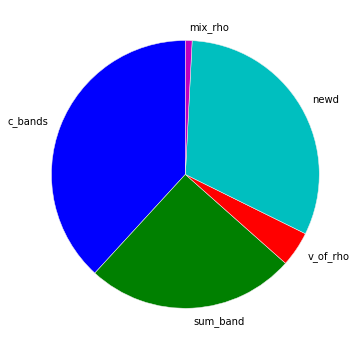

In [7]:
#toPlot.plot(kind='pie',subplots=True)
#use matplotlib for more controll
plt.figure(figsize=(6,6))
plt.pie(toPlot,labels = toPlot.index,startangle=90)
plt.show()

#the idea is to make a pie or a bar plot for every parent and make a nice figure

In [8]:
def getBodyFigure(datas) :
    theParents = datas[datas.Section == "BODY"].Parent.unique()
    subplotGridHight = len(theParents)/2 + len(theParents)%2
    fig = plt.figure(1,figsize=(18,18))
    k = 0
    h = 0
    fig.suptitle("Profiling", fontsize=14, fontweight='bold')
    for parent in theParents:
        #print parent
        #print k,h
        ax = plt.subplot2grid((subplotGridHight,2), (k,h))
        h = (h+1)%2
        if h%2 == 0 : k = k+1

        toBarPlot = datas[(datas.Parent == parent) & (datas.Section == "BODY")][['#name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]

        #sort by most cpu demanding
        toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

        cpuOffsets = [0]
        wallOffsets = [0]
        callsOffsets = [0]
        for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
            cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
            wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
            callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
        cpuOffsets = cpuOffsets[:-1]
        wallOffsets = wallOffsets[:-1]
        callsOffsets = callsOffsets[:-1]

        cmap = plt.cm.jet
        zipped = zip(toBarPlot['#name'],
                     toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
                     cpuOffsets,wallOffsets,callsOffsets,
                     range(0,len(toBarPlot['#name'])))
        #print in reverse order because we wnat the bottom stack to be the least in the legend
        #unfortunately managing the legend order is not so easy
        for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
            plt.bar([1,3,5], #position of the bar
                   [cpu,wall,calls],#height
                   width=1,
                   bottom=[cpuO,wallO,callsO],
                    color = cmap(1- (float(nth)/len(toBarPlot['#name']))),
                    label = name 
                  )

        plt.xlim(0,10)
        plt.ylim(0,110)
        plt.title(parent)
        plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
        plt.legend()
    return fig

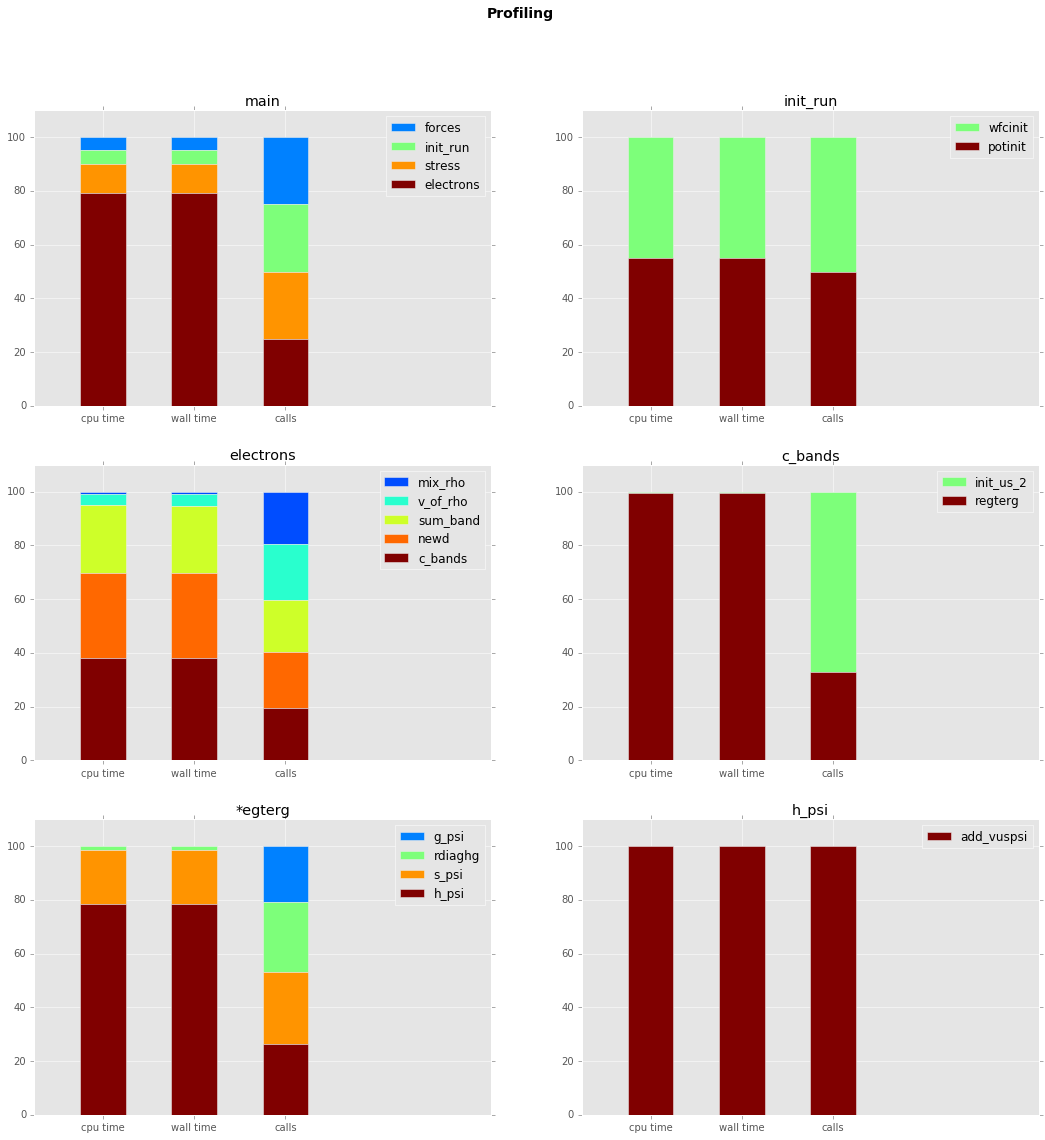

In [9]:
theFigure = getBodyFigure(datas)

In [11]:

def getStackedGlobalPlot(datas) :
    return datas[['#name','cpuTime','wallTime']].set_index('#name').plot(kind='bar',figsize=(10,6))


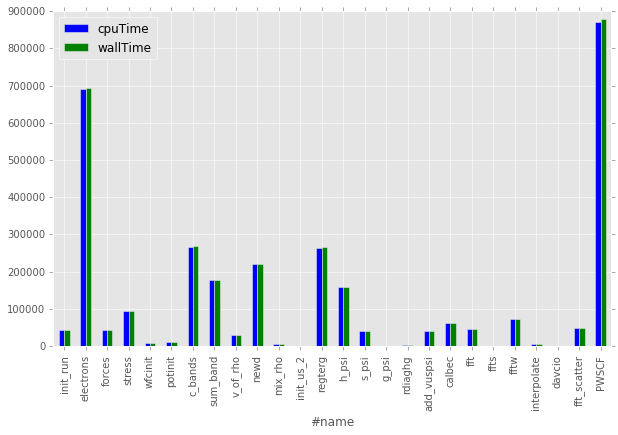

In [12]:
getStackedGlobalPlot(datas)

In [16]:
groupped=datas.groupby('Parent')

In [17]:
groupped

In [18]:
groupped.groups

{'*egterg': [13, 14, 15, 16],
 'c_bands': [11, 12],
 'electrons': [6, 7, 8, 9, 10],
 'h_psi': [17],
 'init_run': [4, 5],
 'main': [0, 1, 2, 3]}

In [29]:
for name,group in groupped :
    print "name: %s"%name
    print min(group.index),max(group.index)
    

name: *egterg
13 16
name: c_bands
11 12
name: electrons
6 10
name: h_psi
17 17
name: init_run
4 5
name: main
0 3
